In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [3]:
data = pd.read_csv('/content/drive/MyDrive/oasis_longitudinal.csv')
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


# Pre-processing and Data Engineering

In [4]:
# Remove unwanted columns

unwanted_columns=['Hand','MRI ID','Subject ID','Visit']
data.drop(unwanted_columns,axis=1,inplace=True)
data.head()

,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,0,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,560,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [5]:
# Encode categorical features into numeric

encoder = LabelEncoder()
data['Group']=encoder.fit_transform(data['Group'])
data['M/F']=encoder.fit_transform(data['M/F'])
data.head()

,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,2,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,0,1,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,1,560,1,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,1,1895,1,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [6]:
# Handle the null values by removing or replacing

data.dropna(inplace=True)
data.head()

,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,2,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
5,2,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,2,538,0,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,2,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039


In [7]:
# Identify feature and target and split it into train test

X=data.drop('Group',axis=1)
Y=data['Group']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

# EDA & Visualization

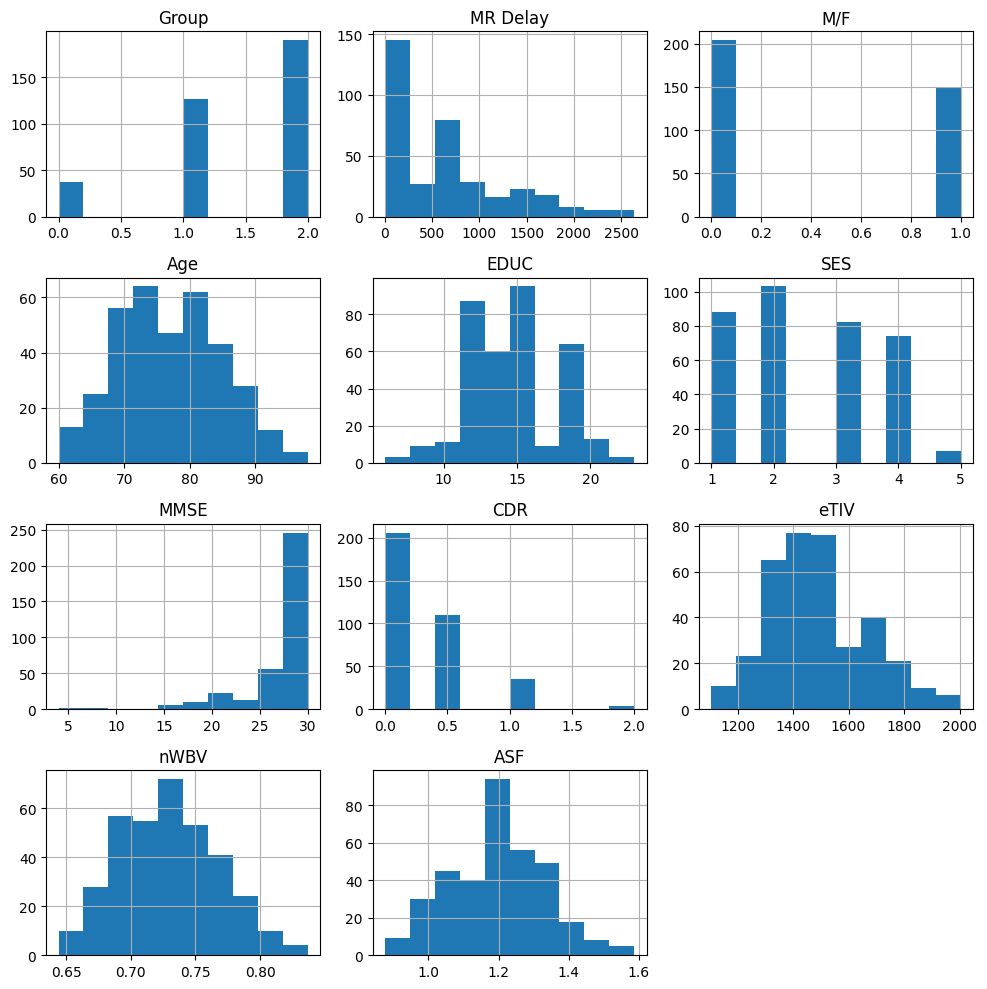

In [8]:
# Plot the distribution of all the variables using a histogram

data.hist(figsize=(10,10))
plt.tight_layout()
plt.show()

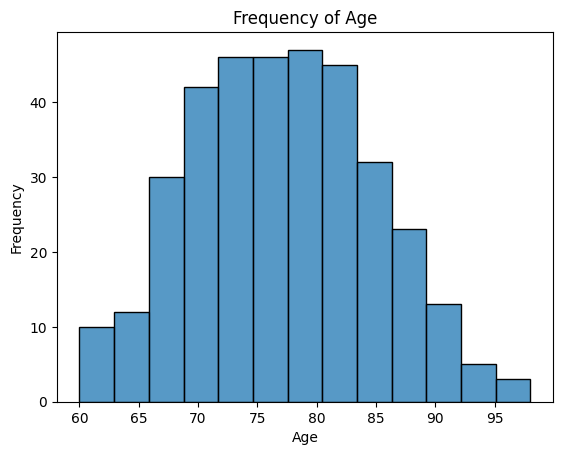

In [9]:
# Visualize the frequency of Age

sns.histplot(data['Age'])
plt.title('Frequency of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

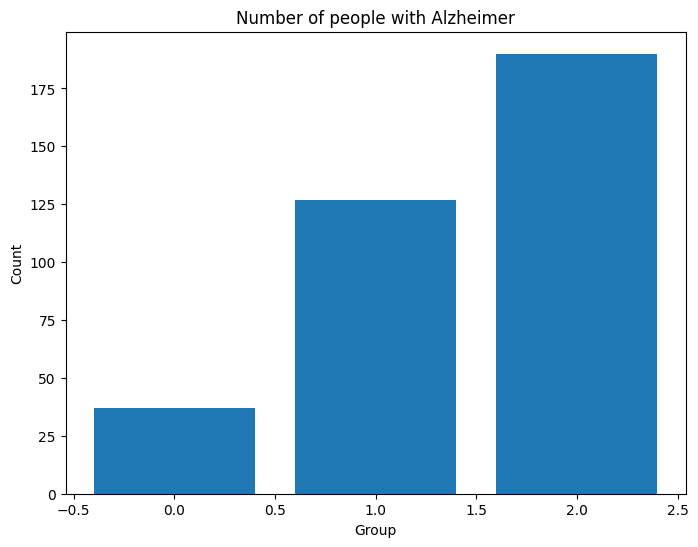

In [10]:
# How many people have Alzheimer? Visualize with an appropriate plot

alzheimer_count = data[data['Group']!='NonDemented']['Group'].value_counts()
plt.figure(figsize=(8,6))
plt.bar(alzheimer_count.index,alzheimer_count.values)
plt.title('Number of people with Alzheimer')
plt.xlabel('Group')
plt.ylabel('Count')
plt.show()

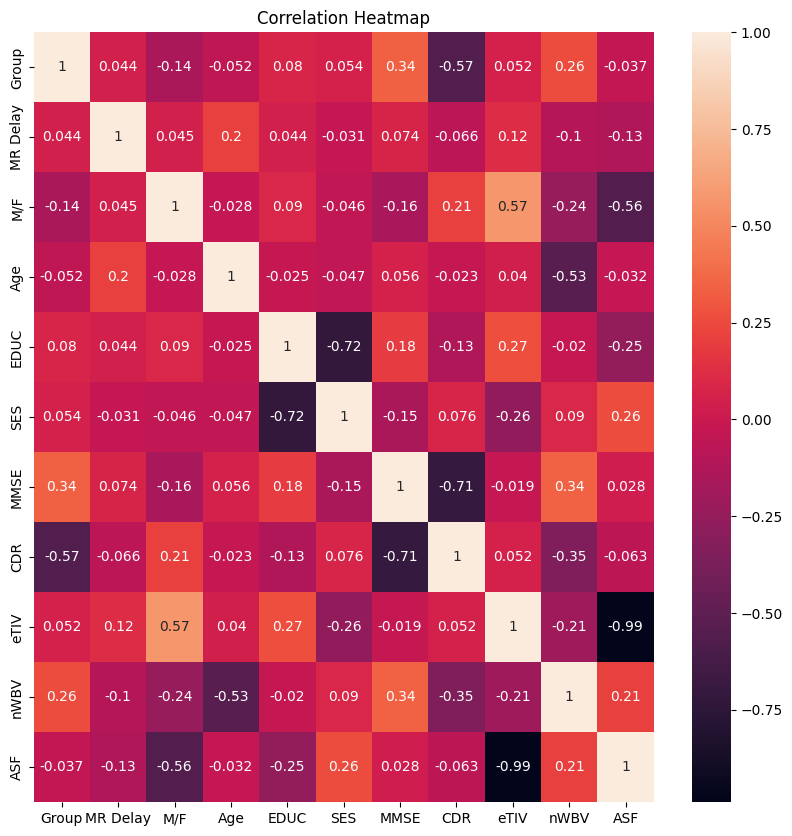

In [11]:
# Calculate the correlation of features and plot the heatmap

plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [12]:
class OVR_SGD:

    # Initialise OVR_SGD object
    def __init__(self,base_classifier):

        # Base binary classifier used for each binary classification task
        self.base_classifier = base_classifier

        # Store the binary classifiers trained for each class
        self.classifiers = {}

        # Store theta for each class
        self.thetas = {}
        self.accuracies = {}

    # Train a binary classifier for each class using SGD
    def fit(self,X,Y):

        # Get unique class labels
        self.classes = np.unique(Y)

        # Iterate over each class
        for c in self.classes:

            # Create binary label vector for class c
            binary_Y = np.where(Y == c,1,0)

            # Create base classifier with logistic loss and other parameters
            classifier = self.base_classifier(loss = 'log_loss',max_iter = 10000,random_state = 42)

            # Fit classifier for class c
            classifier.fit(X,binary_Y)

            #Store the classifier for class c
            self.classifiers[c] = classifier

            # Store the theta values for class c
            self.thetas[c] = classifier.coef_

            # Calculate the accuracy for class c
            Y_pred = classifier.predict(X)
            accuracy = accuracy_score(binary_Y,Y_pred)
            self.accuracies[c] = accuracy

    # Predict the class labels for new data
    def predict(self,X):

        # Initialise array to store predicted probabilities
        pred_probs = np.zeros((X.shape[0],len(self.classes)))

        # Iterate over each class
        for i,c in enumerate(self.classes):

            # Calculate the dot product of X and the learned theta values for class c
            z = np.dot(X,self.thetas[c].reshape(-1))
            z_scaled = np.clip(z,-500,500)

            # Apply the sigmoid function to get the predicted probability for class c
            pred_probs[:,i] = 1/(1 + np.exp(-z_scaled))

        # Return the class with the highest predicted probability for each sample
        return np.argmax(pred_probs,axis = 1)

    def get_thetas(self):
        return self.thetas

ovr_classifier_sgd = OVR_SGD(SGDClassifier)
ovr_classifier_sgd.fit(X_train,Y_train)
Y_pred = ovr_classifier_sgd.predict(X_test)
print(accuracy_score(Y_test,Y_pred))

for c in ovr_classifier_sgd.classes:
    print(f"Accuracy for class {c}: {ovr_classifier_sgd.accuracies[c]}")

0.36619718309859156
Accuracy for class 0: 0.8975265017667845
Accuracy for class 1: 0.3568904593639576
Accuracy for class 2: 0.5406360424028268
